In [128]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import random

In [4]:
df = pd.read_csv('cleaned_corpora.csv')

In [227]:
copy.columns

Index(['author', 'id_x', 'per_curiam', 'clean_text', 'case_name',
       'citation_count', 'citations', 'date_filed', 'docket', 'judges',
       'lexis_cite', 'nature_of_suit', 'non_participating_judges', 'panel',
       'posture', 'precedential_status', 'resource_uri',
       'scdb_decision_direction', 'scdb_id', 'scdb_votes_majority',
       'scdb_votes_minority', 'source', 'sub_opinions', 'corpora'],
      dtype='object')

In [5]:
# one missing year
df.at[1807, 'year'] = 2019

### BoW >> TF-IDF

Get columns

In [6]:
cols = ['id_x', 'year', 'case_name', 'corpora']

In [7]:
corp = df[cols].copy()

In [232]:
corp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4579 entries, 0 to 4578
Data columns (total 4 columns):
id_x         4579 non-null int64
year         4579 non-null float64
case_name    4578 non-null object
corpora      4579 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 143.2+ KB


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# fit = bow; .get_feature_names()
vect = CountVectorizer(ngram_range=(1,3))

# dense: pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

In [131]:
corp['corpora'].iloc[:5].values.flatten().tolist()

['wall worthyvthe commissionerssupreme court united state mr boyce move dismiss writ want jurisdiction ground plaintiff errormr scheffer contra chief justice deliver opinion courtit manifest court jurisdiction present cause decision supreme court north carolina validity treaty act congress authority exercise united state favor validity statute authority exercise state allege repugnant constitution treaty law united statesit true brief counsel plaintiff urge right plaintiff protect st section th amendment right appear set specially claimed state court essential jurisdiction herewe authority therefore examine question present record must allow motion defendant error dismiss cause forwant jurisdiction',
 'wall osbornvnicholson et alsupreme court united state mr p phillips mr ah garland plaintiff error messrs watkins rise contramr justice swayne state case deliver opinion courtthe plaintiff error brought suit th february court declare upon promissory note make defendant error date march th

In [11]:
# .transform() = dtm; matrix populated with token counts to represent our messages in sparse format

# def wm_to_df(wm, feat_names):
#    # create an index for each row
#    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
#    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
#                      columns=feat_names)
#    return(df)
#

def make_bow(df_col):
    #custom_vec = CountVectorizer(ngram_range=(1,3))
    custom_vec = CountVectorizer(strip_accents="unicode", stop_words)
    corpora = df_col.values.flatten().tolist()
    wm = custom_vec.fit_transform(corpora)
    vocab = custom_vec.vocabulary_
    tokens = custom_vec.get_feature_names()
    #df = wm_to_df(wm, tokens)
    
    return wm, tokens, vocab #df, tokens

# Tune the vectorizer with gridsearch...
# ngram_range=(1, 2) # number of ngrams
# max_df=0.75 # ignore terms appearing in >75% of documents 
# min_df=1 # ignore terms that only appear in x documents (dangerous bc of case names)

In [12]:
wordmatrix, features, vocab = make_bow(corp['corpora'])

In [14]:
def bow_df(vocab):
    vv = list(vocab.values())
    vk = list(vocab.keys())
    count_df = pd.DataFrame(list(zip(vk,vv)))
    count_df.columns = ['Word', 'Count']
    count_df.sort_values(by='Count', ascending=False, inplace=True)
    return count_df

count_df = bow_df(vocab)

In [191]:
count_df

,Word,Count
95376,ถถ,194125
45320,งง,194124
10593,ætna,194123
106542,zzz,194122
71374,zywicke,194121
100798,zyme,194120
145852,zylstra,194119
94477,zykan,194118
112058,zygmunt,194117
124789,zydok,194116


In [17]:
import numpy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

In [135]:
from sklearn.feature_extraction import text 

my_additional_stop_words=['united', 'federal', 'district', 'right', 'id', 'opinion',
'law', 'case', 'state', 'court','sentence','defendant','petitioner',
'statute','case', 'ct', 'mr', 'ถถ', 'งง', 'zzz','supra','infra','appellant','appellee']
more_stop_words=['act', 'make', 'ante', 'cite', 'claim', 'respondent','rule','shall','judgment','say']

stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [58]:
# vectorizer to convert raw documents to TF/IDF matrix

vectorizer = TfidfVectorizer(stop_words=stop_words,
                             strip_accents="unicode",
                             use_idf=True, 
                             smooth_idf=True)

# Normalizes the vector (L2 norm of 1.0) to normalize 
# the effect of document length on tf-idf

normalizer = Normalizer(copy=False)

In [59]:
# Perform SVD
# Project the tfidf vectors onto the first N principal components.

svd_model = TruncatedSVD(n_components=100,         # num dimensions
                         algorithm='randomized',
                         n_iter=10)

lsa_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model),
                            ('norm', normalizer)])

In [21]:
def lsa_transform(df_col):
    corpora = df_col.values.flatten().tolist()
    lsa_matrix = lsa_transformer.fit_transform(corpora)

    print(f"tf-idf params: {lsa_transformer.steps[0][1].get_params()}")

    # Get the words that correspond to each of the features.
    feat_names = lsa_transformer.steps[0][1].get_feature_names()
    vocab = lsa_transformer.steps[0][1].vocabulary_
    
    return lsa_matrix, feat_names, vocab

lsa_matrix, feat_names, lsa_vocab = lsa_transform(corp['corpora'])

tf-idf params: {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': None, 'min_df': 1, 'ngram_range': (1, 1), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': frozenset({'are', 'put', 'among', 'already', 'take', 'itself', 'your', 'above', 'some', 'whom', 'yet', 'part', 'hereupon', 'been', 'ours', 'since', 'afterwards', 'none', 'will', 'often', 'same', 'fifteen', 'both', 'through', 'eg', 'may', 'its', 'i', 'for', 'to', 'thru', 'amount', 'ever', 'sometimes', 'de', 'ourselves', 'without', 'him', 'hers', 'cant', 'such', 'whereupon', 'งง', 'yourself', 'their', 'off', 'five', 'somewhere', 'move', 'sincere', 'federal', 'rather', 'formerly', 'alone', 'nine', 'myself', 'keep', 'mill', 'couldnt', 'find', 'further', 'this', 'hundred', 'a', 'court', 'them', 'between', 'although', 'when', 'enough', 'mine', 're', 'interest', 'what', 'empty', 'id

In [22]:
lsa_matrix

array([[ 5.95680658e-01, -3.29499257e-02, -8.02992724e-02, ...,
         3.65053175e-02, -8.60266007e-02, -2.72642648e-02],
       [ 3.28573172e-01, -5.41233614e-02, -1.75900766e-01, ...,
         4.65462215e-02, -2.98833655e-01,  1.64875783e-03],
       [ 5.14405756e-01,  1.50660311e-01, -3.58792597e-02, ...,
        -1.59492971e-02, -1.11110792e-01, -1.14017217e-01],
       ...,
       [ 4.47183069e-01, -6.43620708e-02, -2.61567267e-01, ...,
        -6.39565586e-02, -3.72706352e-02, -2.27679458e-02],
       [ 5.32268019e-01, -2.39050461e-01, -7.00855888e-02, ...,
        -4.77057340e-04, -7.78777086e-02,  1.05030417e-01],
       [ 4.37605131e-01, -1.30584150e-01, -1.36273205e-01, ...,
         1.77815563e-02,  1.01386066e-01,  3.10702947e-02]])

In [23]:
feat_names

['2years',
 'aa',
 'aaa',
 'aaarated',
 'aabd',
 'aac',
 'aaccord',
 'aaccordingly',
 'aact',
 'aadc',
 'aadvertising',
 'aaf',
 'aafter',
 'aaidd',
 'aaidddefinition',
 'aakki',
 'aall',
 'aalmost',
 'aalso',
 'aalthough',
 'aamd',
 'aamoth',
 'aamr',
 'aan',
 'aandahl',
 'aanother',
 'aany',
 'aap',
 'aapart',
 'aapg',
 'aappeals',
 'aappellant',
 'aappellants',
 'aappellees',
 'aapplication',
 'aapproximately',
 'aar',
 'aaron',
 'aaronson',
 'aarp',
 'aarticle',
 'aarticles',
 'aashto',
 'aaside',
 'aasked',
 'aassembled',
 'aassuming',
 'aastonishingly',
 'aat',
 'aaup',
 'ab',
 'aba',
 'ababna',
 'ababy',
 'abackstop',
 'abacus',
 'abad',
 'abaddon',
 'abadinsky',
 'abaguidebook',
 'abailout',
 'abaj',
 'abaker',
 'abalancing',
 'abaldrige',
 'aban',
 'abando',
 'abandon',
 'abandoned',
 'abandonedcapital',
 'abandonedchaving',
 'abandonedhow',
 'abandonediin',
 'abandonedimy',
 'abandonedit',
 'abandonedthe',
 'abandonedthese',
 'abandonedthis',
 'abandonin',
 'abandoningthe',
 

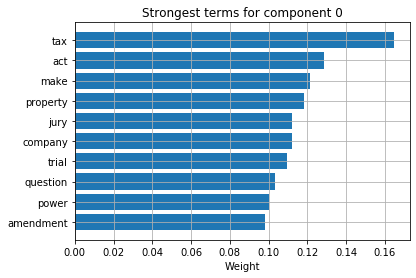

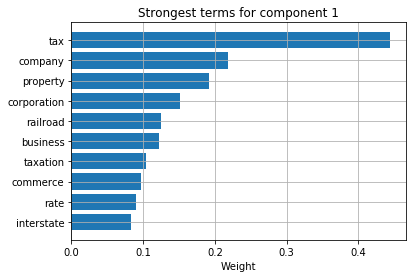

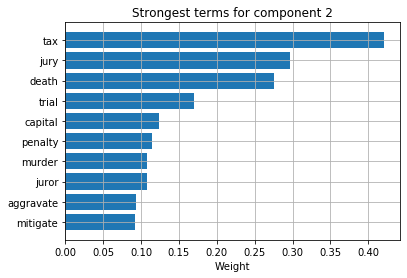

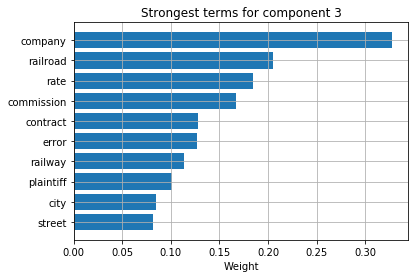

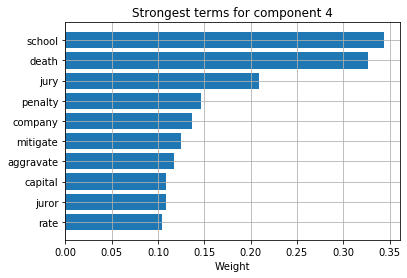

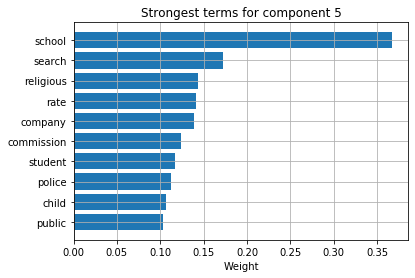

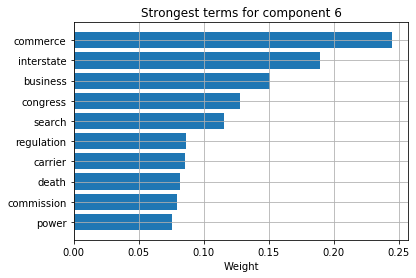

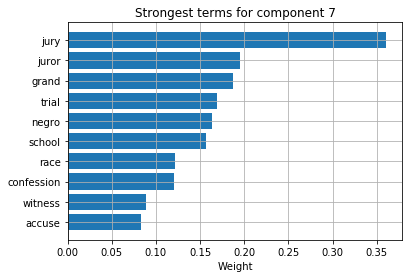

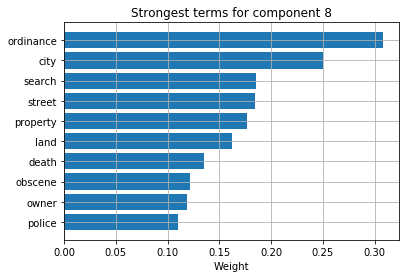

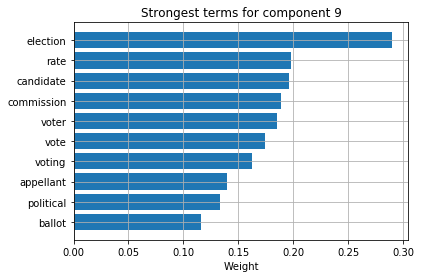

In [36]:
import matplotlib.pyplot as plt
import matplotlib
for component_num in range(0, 10):

    comp = lsa_transformer.steps[1][1].components_[component_num]
    
    # Sort the weights in the first component and get indices
    indices = numpy.argsort(comp).tolist()
    
    # Reverse order (largest weights first)
    indices.reverse()
    
    # Get top 10 terms for component        
    terms = [feat_names[weight_index] for weight_index in indices[0:10]]    
    weights = [comp[weight_index] for weight_index in indices[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = numpy.arange(10) + .5    # the bar centers on the y axis
    
    plt.figure(component_num)
    plt.barh(positions, weights, align="center")
    plt.yticks(positions, terms)
    plt.xlabel("Weight")
    plt.title(f"Strongest terms for component {component_num}")
    plt.grid(True)
    plt.savefig(f"terms_for_component_{component_num}")
    plt.show()

In [85]:
first_year = 1875
last_year  = 2018
increment  = 10
overlap    = increment // 2
# ------------------------

# ------------------------

# intended use: include left, exclude right
# half-closed, half-open interval [a, b)
def build_year_ranges(first, last, inc, over):
    year_ranges = []
    for n in range(first, last, over):
        year_ranges.append((n, n + inc))
    return year_ranges


# warning: years must have the same index as data
def put_data_under_year_ranges(data, years, year_ranges):

    # assert len(data) == len(years), \
    # "get_content_under_ranges: data and years do not match length"

    # build a dict with keys = year_ranges, with a list for each range
    data_ranges = dict()
    for y in year_ranges:
        data_ranges[y] = []

    # bin all the data by range - each row should fall in two bins, 
    # if ranges are cleanly overlapped

    # if data is a list
    for i in range(len(data)):
        for y in year_ranges:
            if y[0] <= years[i] and years[i] < y[1]:
                data_ranges[y].append(data[i])
                # this should happen twice for every entry except 
                # the very oldest and the very newest

    # pandas df
    return data_ranges

# ------------

def run_year_range_build(): # main
    
    cases = []
    years = []
    corpora = []
                  
    for i in range(500):
        years.append(first_year, last_year)
        i = 0, len(corpora)-1
        j = 0, len(corpora)-1
        cases.append(corpora[i] + ' ' + corpora[j])
        
    # and bin them
    bins = build_year_ranges(first_year, last_year, increment, overlap)
    binned_data = put_data_under_year_ranges(cases, years, bins)

In [38]:
corp_list = corp["corpora"].values.flatten().tolist()
year_list = corp["year"].values.flatten().tolist()

In [86]:
year_ranges = build_year_ranges(first_year, last_year, increment, overlap)

In [87]:
binned_data = put_data_under_year_ranges(corp_list, year_list, year_ranges)

In [88]:
year_ranges

[(1875, 1885),
 (1880, 1890),
 (1885, 1895),
 (1890, 1900),
 (1895, 1905),
 (1900, 1910),
 (1905, 1915),
 (1910, 1920),
 (1915, 1925),
 (1920, 1930),
 (1925, 1935),
 (1930, 1940),
 (1935, 1945),
 (1940, 1950),
 (1945, 1955),
 (1950, 1960),
 (1955, 1965),
 (1960, 1970),
 (1965, 1975),
 (1970, 1980),
 (1975, 1985),
 (1980, 1990),
 (1985, 1995),
 (1990, 2000),
 (1995, 2005),
 (2000, 2010),
 (2005, 2015),
 (2010, 2020),
 (2015, 2025)]

In [89]:
for k,v in binned_data.items():
    print(f"Number of cases decided circa {k}: {len(v)}")

Number of cases decided circa (1875, 1885): 34
Number of cases decided circa (1880, 1890): 62
Number of cases decided circa (1885, 1895): 108
Number of cases decided circa (1890, 1900): 164
Number of cases decided circa (1895, 1905): 236
Number of cases decided circa (1900, 1910): 296
Number of cases decided circa (1905, 1915): 343
Number of cases decided circa (1910, 1920): 414
Number of cases decided circa (1915, 1925): 418
Number of cases decided circa (1920, 1930): 357
Number of cases decided circa (1925, 1935): 311
Number of cases decided circa (1930, 1940): 291
Number of cases decided circa (1935, 1945): 265
Number of cases decided circa (1940, 1950): 246
Number of cases decided circa (1945, 1955): 223
Number of cases decided circa (1950, 1960): 197
Number of cases decided circa (1955, 1965): 282
Number of cases decided circa (1960, 1970): 405
Number of cases decided circa (1965, 1975): 595
Number of cases decided circa (1970, 1980): 765
Number of cases decided circa (1975, 1985)

In [97]:
num_cases = list(zip(years_k, values_v))

In [116]:
num_df = pd.DataFrame(num_cases)
num_df.columns = ["Years", "Approx. No. Opinions Issued"]
num_df.Years = num_df.Years.apply(lambda x: (x[0]+x[1])/2)
fig = px.bar(num_df, x='Years', y='Approx. No. Opinions Issued')
fig.show()

In [91]:
def LSA_per_bin(corpora, pipe=lsa_transformer):

    # assert: first pipeline component must be tfidf/count vectorizer
    lsa_matrix = pipe.fit_transform(corpora)

    # Get the words that correspond to each of the features.
    feat_names = pipe.steps[0][1].get_feature_names()
    vocab = pipe.steps[0][1].vocabulary_

    for component_num in range(0, 10):
    
        comp = pipe.steps[1][1].components_[component_num]
        
        # Sort the weights in the first component and get indices
        indices = np.argsort(comp).tolist()
        
        # Reverse order (largest weights first)
        indices.reverse()
        
        # Get top 10 terms for component        
        terms = [feat_names[weight_index] for weight_index in indices[0:10]]    
        weights = [comp[weight_index] for weight_index in indices[0:10]] 
        terms.reverse()
        weights.reverse()
       
        # Display these terms and their weights as a horizontal bar graph.    

        bin_terms = terms
        bin_weights = weights
        bin_matrix = lsa_matrix
        bin_feat_names = feat_names
        bin_vocab = vocab
        
        return {"terms": bin_terms, "weights": bin_weights, "matrix": bin_matrix, "feat_names": bin_feat_names, "vocab": bin_vocab}
        
def run_LSA_on_bins(binned_data, year_ranges, pipe=lsa_transformer):    
    
    LSA_ranges = dict()
    for y in year_ranges:
        LSA_ranges[y] = []
    
    for y in year_ranges:
        LSA_ranges[y].append(LSA_per_bin(binned_data[y], pipe))
        print(f"Running cases from: {y}") 
        
    return LSA_ranges    
    

In [92]:
lsa = run_LSA_on_bins(binned_data, year_ranges, lsa_transformer)

Running cases from: (1875, 1885)
Running cases from: (1880, 1890)
Running cases from: (1885, 1895)
Running cases from: (1890, 1900)
Running cases from: (1895, 1905)
Running cases from: (1900, 1910)
Running cases from: (1905, 1915)
Running cases from: (1910, 1920)
Running cases from: (1915, 1925)
Running cases from: (1920, 1930)
Running cases from: (1925, 1935)
Running cases from: (1930, 1940)
Running cases from: (1935, 1945)
Running cases from: (1940, 1950)
Running cases from: (1945, 1955)
Running cases from: (1950, 1960)
Running cases from: (1955, 1965)
Running cases from: (1960, 1970)
Running cases from: (1965, 1975)
Running cases from: (1970, 1980)
Running cases from: (1975, 1985)
Running cases from: (1980, 1990)
Running cases from: (1985, 1995)
Running cases from: (1990, 2000)
Running cases from: (1995, 2005)
Running cases from: (2000, 2010)
Running cases from: (2005, 2015)
Running cases from: (2010, 2020)
Running cases from: (2015, 2025)


In [119]:
lsa[(1875, 1885)][0]

{'terms': ['shall',
  'amendment',
  'make',
  'race',
  'act',
  'color',
  'power',
  'constitution',
  'person',
  'citizen'],
 'weights': [0.13918392850743164,
  0.14247924852182436,
  0.1429296657984402,
  0.14443305902834727,
  0.1466611070245255,
  0.15388617245105637,
  0.15688915430027356,
  0.16455021103386852,
  0.21145153135060057,
  0.21214614640016163],
 'matrix': array([[ 0.37993257, -0.20577323, -0.07654156, ..., -0.04394689,
         -0.01336676,  0.01667009],
        [ 0.53916258,  0.46430468,  0.38313968, ..., -0.01457283,
         -0.22002224, -0.09096441],
        [ 0.49654891, -0.24364156, -0.25497061, ..., -0.01704646,
         -0.01021632, -0.00260896],
        ...,
        [ 0.35530288, -0.02371534,  0.03284325, ...,  0.00236258,
         -0.01096284,  0.00933163],
        [ 0.67207594,  0.4493158 ,  0.25918105, ..., -0.01233867,
          0.30103515,  0.28662365],
        [ 0.35831395, -0.06747408,  0.30935186, ...,  0.08589053,
          0.00810724,  0.021258

In [93]:
for k,v in lsa.items():
    print(f"terms for {k}:\n{lsa[k][0]['terms']}")

terms for (1875, 1885):
['shall', 'amendment', 'make', 'race', 'act', 'color', 'power', 'constitution', 'person', 'citizen']
terms for (1880, 1890):
['citizen', 'make', 'shall', 'constitution', 'company', 'property', 'act', 'power', 'say', 'person']
terms for (1885, 1895):
['shall', 'judgment', 'corporation', 'power', 'act', 'railroad', 'property', 'say', 'tax', 'company']
terms for (1890, 1900):
['power', 'question', 'corporation', 'constitution', 'railroad', 'act', 'say', 'property', 'company', 'tax']
terms for (1895, 1905):
['power', 'corporation', 'make', 'constitution', 'question', 'act', 'say', 'company', 'property', 'tax']
terms for (1900, 1910):
['constitution', 'power', 'question', 'say', 'error', 'act', 'make', 'company', 'property', 'tax']
terms for (1905, 1915):
['railroad', 'plaintiff', 'power', 'property', 'say', 'make', 'error', 'act', 'company', 'tax']
terms for (1910, 1920):
['city', 'say', 'plaintiff', 'property', 'make', 'error', 'railroad', 'act', 'tax', 'company']


In [ ]:
def kmeans_topics(binned_data, n_clusters):
    vectorizer = TfidfVectorizer(stop_words=stop_words,
                             strip_accents="unicode",
                             use_idf=True, 
                             smooth_idf=True)
    kmeans = KMeans(n_clusters).fit(vectorizer)
    kmeans.predict(tfidf_vectorizer.transform(lines_for_predicting))

In [ ]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)

In [127]:
# for k in lsa.keys():
#     words = lsa[k][0]['terms']
#     colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(10)]
#     weights = lsa[k][0]['weights']
#     
#     
#     import plotly
#     import plotly.graph_objs as go
#     from plotly.offline import plot
#     import random
#     data = go.Scatter(x=[random.random() for i in range(10)],
#                      y=[random.random() for i in range(10)],
#                      mode='text',
#                      text=words,
#                      marker={'opacity': 0.3},
#                      textfont={'size': weights,
#                                'color': colors})
#     layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
#                         'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
#     fig = go.Figure(data=[data], layout=layout)